In [106]:
import tensorflow as tf
from tensorflow import keras as k
import tensorflow_probability as tfp
import numpy as np
import math

import matplotlib.pyplot as plt

import asmsa

In [154]:

#grid

In [157]:
prior=tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])
s = prior.sample(1000)
h = _Hist2D(s)


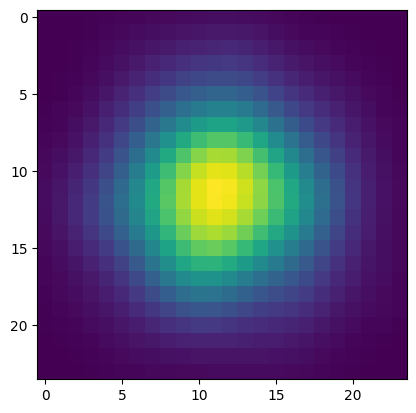

In [158]:
plt.imshow(h)
plt.show()

In [ ]:
s[11]

In [ ]:
class _TransposeLayer(k.layers.Layer):
    def __init__(self,batch_size=None):
        super().__init__()
        self.batch_size = batch_size
        
    def call(self,inputs):
        if self.batch_size:
            return tf.transpose(tf.reshape(inputs,[self.batch_size,inputs.shape[1]]))
        return tf.transpose(inputs)

In [ ]:
inp = k.Input(shape=(2,))
out = k.layers.Dense(10)(inp)
out = _TransposeLayer(batch_size=3)(out)
out = k.layers.Dense(10)(out)
#out = _TransposeLayer()(out)
out = k.layers.Dense(1)(out)
out = _TransposeLayer()(out)
out = k.layers.Dense(1)(out)
mod = k.Model(inp,out)
mod.summary()

In [ ]:
mod.compile()

In [ ]:
mod.call(tf.constant([[1,2],[3,4],[5,6]],tf.float32))

In [197]:
_default_hp = {
    'activation' : 'gelu',
    'ae_loss_fn': 'MeanSquaredError',
    'optimizer': 'Adam',
    'learning_rate' : 0.0002,
    'kde_sigma': 0.01,
    'kl_weight': 1.0,
}

@tf.function
def _KDEProb(ref,qry,sigma=1.):
    rsigma2 = -1./(2.*sigma*sigma)

    refs = tf.concat([tf.slice(tf.shape(qry),[0],[1]),tf.shape(ref)],0)
    qrys = tf.concat([tf.slice(tf.shape(ref),[0],[1]),tf.shape(qry)],0)
 
    mref = tf.broadcast_to(ref,refs)
    mqry = tf.broadcast_to(qry,qrys)
    mqry = tf.transpose(mqry,[1,0,2]) # XXX: exactly 1D shape of latent space dim

    dist2 = tf.math.reduce_sum(
        tf.math.pow(mref-mqry,2),
        axis=2
    )
    kdes = tf.exp(dist2 * rsigma2)
    kde = tf.reduce_mean(kdes,axis=1)\
        * tf.math.pow(tf.constant(2.*math.pi), tf.cast(tf.shape(ref)[1],tf.float32) * -.5)\
        / sigma
    return kde

class BatchedAAEModel(k.models.Model):
    
    def __init__(self,mol_shape,latent_dim=2,ae_layers=[64,32,8],disc_layers=[8,16,8],bins=25,low=-3.,high=3,
                 prior=tfp.distributions.MultivariateNormalDiag(loc=[0.,0.]),hp=_default_hp):
        
        super().__init__()
        self.hp = hp
        self.latent_dim = latent_dim
        self.prior = prior
        self.bins = bins
        self.low = low
        self.high = high

        self.grid=tf.repeat(tf.linspace(tf.constant([low,0],tf.float32),[high,0],bins),bins,axis=0)+\
            tf.tile(tf.linspace(tf.constant([0,low],tf.float32),[0,high],bins),[bins,1])

        inp = k.Input(shape = mol_shape)
        out = inp

        for i,n in enumerate(ae_layers):
            out = k.layers.Dense(n,activation=hp['activation'],name=f'enc_{i}')(out)
            out = k.layers.BatchNormalization(momentum=0.8,name=f'enc_bn_{i}')(out)

        out = k.layers.Dense(latent_dim,name='enc_out')(out)
        latent = out

        for i,n in enumerate(reversed(ae_layers)):
            out = k.layers.Dense(n,activation=hp['activation'],name=f'dec_{i}')(out)
            out = k.layers.BatchNormalization(momentum=0.8,name=f'dec_bn_{i}')(out)

        out = k.layers.Dense(mol_shape,activation=hp['activation'],name='dec_out')(out)

        self.enc = k.Model(inputs=inp,outputs=latent)
        self.dec = k.Model(inputs=latent,outputs=out)

        """out = _TransposeLayer(batch_size=batch_size)(latent)
        for i,n in enumerate(disc_layers):
            out = k.layers.Dense(n,activation=hp['activation'],name=f'disc_{i}')(out)
            out = k.layers.BatchNormalization(momentum=0.8,name=f'disc_bn_{i}')(out)
            out = _TransposeLayer()(out)

        out = k.layers.Dense(1,activation=hp['activation'])(out)
        out = _TransposeLayer()(out)
        out = k.layers.Dense(1,activation=hp['activation'])(out)

        self.disc = k.Model(inputs=latent,outputs=out)"""
        
        inp = k.Input(shape=(bins,bins,1))
        out = k.layers.Conv2D(10,5,padding='same',activation=hp['activation'])(inp)
        out = k.layers.Conv2D(10,5,padding='same',activation=hp['activation'])(out)
        out = k.layers.Flatten()(out)
        out = k.layers.Dense(50,activation=hp['activation'])(out)
        out = k.layers.Dense(1,activation=hp['activation'])(out)
        self.disc = k.Model(inputs=inp,outputs=out)
        
    def Hist2D(self,x):
        return tf.reshape(_KDEProb(x,self.grid,sigma=.5),(self.bins,self.bins))
        
    def compile(self,optimizer=None,lossfn=k.losses.MeanSquaredError()):
        if optimizer is None:
            optimizer = self.hp['optimizer']

        if isinstance(optimizer,str):
            optimizer = k.optimizers.legacy.__dict__[optimizer]

        super().compile(optimizer = optimizer(learning_rate=self.hp['learning_rate']))
        self.ae_weights = self.enc.trainable_weights + self.dec.trainable_weights
        self.lossfn = lossfn
        self.discloss = k.losses.BinaryCrossentropy(from_logits=True)
   
    @tf.function
    def train_step(self,batch):
        prob_shift = 1e-15
        
        if isinstance(batch,tuple):
            batch = batch[0]

        with tf.GradientTape() as aetape:
            out = self.dec(self.enc(batch))
            loss = self.lossfn(batch,out)

        ae_grad = aetape.gradient(loss,self.ae_weights)
        self.optimizer.apply_gradients(zip(ae_grad,self.ae_weights))

        prior_sample = self.prior.sample(tf.shape(batch)[0])

        latent = self.enc(batch)

        """with tf.GradientTape() as neg_tape:
            neg = self.disc(latent)

        neg_grad = neg_tape.gradient(neg,self.disc.trainable_weights)
        self.optimizer.apply_gradients(zip(neg_grad,self.disc.trainable_weights))

        with tf.GradientTape() as pos_tape:
            pos = -self.disc(prior_sample)

        pos_grad = pos_tape.gradient(pos,self.disc.trainable_weights)
        self.optimizer.apply_gradients(zip(pos_grad,self.disc.trainable_weights))"""

        disc_batch = tf.stack([self.Hist2D(latent),self.Hist2D(prior_sample)],axis=0)
        with tf.GradientTape() as disc_tape:
            out = self.disc(disc_batch)
            disc_loss = self.discloss(tf.constant([0,1],tf.float32),out)

        disc_grad = disc_tape.gradient(disc_loss,self.disc.trainable_weights)
        self.optimizer.apply_gradients(zip(disc_grad,self.disc.trainable_weights))

        for _ in range(5):
            with tf.GradientTape() as cheat_tape:
                cheat = self.disc(tf.reshape(self.Hist2D(self.enc(batch)),(1,self.bins,self.bins)))
                cheat_loss = self.discloss(tf.constant([1],tf.float32),cheat)
    
            cheat_grad = cheat_tape.gradient(cheat_loss,self.enc.trainable_weights)
            self.optimizer.apply_gradients(zip(cheat_grad,self.enc.trainable_weights))
        
        return { 'AE' : loss, 'disc': disc_loss, 'cheat': cheat_loss }


In [ ]:
conf='alaninedipeptide_H.pdb'
gro='aladip_H.gro'
topol='aladip_H.top'
index=None
traj='alaninedipeptide_reduced.xtc'

In [ ]:
import mdtraj as md
import nglview as nv

In [ ]:
tr = md.load(traj,top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
idx=tr[0].top.select("element != H")

tr.superpose(tr[0],atom_indices=idx)
nv.show_mdtraj(tr)

In [ ]:
# gmx pdb2gmx -f alaninedipeptide_H.pdb -o aladip_H.gro -p aladip_H.top -n aladip_H.ndx -water tip3p -ff amber99 -ignh

In [ ]:
np.random.shuffle(tr.xyz)

In [ ]:
train = .7
validation = .15
test = .15

assert train + validation + test == .9999999999999999 or 1

tr_i = len(tr) * train
X_train = tr.slice(slice(0,int(tr_i)))

va_i = len(tr) * validation
X_validate = tr.slice(slice(int(tr_i),int(tr_i)+int(va_i)))

te_i = len(tr) * test
X_test = tr.slice(slice(int(tr_i)+int(va_i),len(tr)))

X_train.xyz.shape, X_validate.xyz.shape, X_test.xyz.shape

In [ ]:
X_train.save_xtc('train.xtc')
X_validate.save_xtc('validate.xtc')
X_test.save_xtc('test.xtc')

In [ ]:
trajs = [X_train, X_validate, X_test]
geoms = []

for i in range(len(trajs)):
    geoms.append(np.moveaxis(trajs[i].xyz,0,-1))
    print(geoms[i].shape)

In [ ]:
tf.data.Dataset.from_tensor_slices(geoms[0]).save('datasets/geoms/train')
tf.data.Dataset.from_tensor_slices(geoms[1]).save('datasets/geoms/validate')
tf.data.Dataset.from_tensor_slices(geoms[2]).save('datasets/geoms/test')

In [ ]:
mols = []
for i in range(len(geoms)):
    sparse_dists = asmsa.NBDistancesDense(geoms[i].shape[0])
    mols.append(asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists]))


In [ ]:
intcoords = []
for i in range(len(mols)):
    intcoords.append(mols[i].intcoord(geoms[i]).T)
    print(intcoords[i].shape)

In [ ]:
tf.data.Dataset.from_tensor_slices(intcoords[0]).save('datasets/intcoords/train')
tf.data.Dataset.from_tensor_slices(intcoords[1]).save('datasets/intcoords/validate')
tf.data.Dataset.from_tensor_slices(intcoords[2]).save('datasets/intcoords/test')

In [ ]:
[train,validate,test] = intcoords

In [ ]:
batch_size = 1024

hp = _default_hp.copy()
hp['learning_rate'] = 0.00005
# normal & uniform, 1024
train_batch = tf.data.Dataset.from_tensor_slices(train).batch(batch_size,drop_remainder=True)

In [ ]:
class _Uniform2d:
    def __init__(self,low=-1.,high=1):
        self.low = tf.constant(low,tf.float32)
        self.high = tf.constant(high,tf.float32)
        self.density = 1./(self.high-self.low)**2
        self.uniform = tfp.distributions.Uniform(low=low,high=high)

    def prob(self,samples):
        out = tf.broadcast_to(self.density,shape=[tf.shape(samples)[0]])
        out *= tf.cast(samples[:,0] >= self.low,tf.float32)
        out *= tf.cast(samples[:,0] <= self.high,tf.float32)
        out *= tf.cast(samples[:,1] >= self.low,tf.float32)
        out *= tf.cast(samples[:,1] <= self.high,tf.float32)
        return out

    def sample(self,n):
        return self.uniform.sample([n,2])
        
        

In [ ]:
import PIL

class _ImageDist:
    def __init__(self,image):
        img = np.array(PIL.Image.open(image),dtype=np.float64)
        img /= 255.
        if len(img.shape) == 3:
            img = np.sum(img,axis=2)

        assert len(img.shape) == 2
        img /= np.sum(img)
        
        
        self.shape = img.shape
        self.flat = tf.convert_to_tensor(np.cumsum(img.flatten()).astype(np.float32))
        self.img = tf.constant(img * img.shape[0]*img.shape[1], tf.float32)

    def sample(self,n):
        u = tf.random.uniform(shape=[n])
        b = tf.broadcast_to(self.flat,u.shape[:-1]+self.flat.shape)
        flati = tf.searchsorted(b,u)
        x = tf.cast(flati % self.shape[1],tf.float32)
        x += tf.random.uniform(x.shape)
        y = tf.cast(flati // self.shape[1],tf.float32)
        y += tf.random.uniform(y.shape)
        x /= self.shape[1]
        y = 1. - y/self.shape[0]
        return tf.stack([x,y],axis=-1)

    def prob(self,samples):
        isamples = tf.cast(tf.stack([1.-samples[:,1],samples[:,0]],axis=1) * self.shape,tf.int32)
        return tf.gather_nd(self.img,isamples)

In [198]:
prior=tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])
#prior = _Uniform2d()
#prior = _ImageDist('mushroom_bw.png')
mod=BatchedAAEModel(train.shape[1], 
            ae_layers=[16,8],
            disc_layers=[8,8],
            prior=prior,
            hp=hp)
mod.compile()

In [199]:
mod.fit(train_batch,epochs=10)

Epoch 1/10
68/68 [==============================] - 4s 12ms/step - AE: 0.2428 - disc: 0.6749 - cheat: 0.6681
Epoch 2/10
68/68 [==============================] - 1s 12ms/step - AE: 0.2019 - disc: 0.4023 - cheat: 0.7363
Epoch 3/10
68/68 [==============================] - 1s 12ms/step - AE: 0.1572 - disc: 0.3079 - cheat: 0.7817
Epoch 4/10
68/68 [==============================] - 1s 11ms/step - AE: 0.1270 - disc: 0.3067 - cheat: 0.7817
Epoch 5/10
68/68 [==============================] - 1s 11ms/step - AE: 0.1101 - disc: 0.3064 - cheat: 0.7817
Epoch 6/10
68/68 [==============================] - 1s 10ms/step - AE: 0.1017 - disc: 0.3062 - cheat: 0.7817
Epoch 7/10
68/68 [==============================] - 1s 11ms/step - AE: 0.0980 - disc: 0.3061 - cheat: 0.7817
Epoch 8/10
68/68 [==============================] - 1s 10ms/step - AE: 0.0965 - disc: 0.3061 - cheat: 0.7817
Epoch 9/10
68/68 [==============================] - 1s 10ms/step - AE: 0.0960 - disc: 0.3061 - cheat: 0.7817
Epoch 10/10
68/68 [

In [159]:
def t_Hist2D(x,min=-1.,max=1.,bins=10):
    zeros = tf.zeros((bins,bins),tf.float32)
# XXX: bounds
    idx = (x - min) * (1./(max - min))
#    idx = tf.cast(idx * bins,tf.int32)
    return tf.reshape(idx[:50],(10,10))

    ones = tf.ones(tf.shape(x)[0])
    return tf.tensor_scatter_nd_add(zeros,idx,ones) / tf.cast(tf.shape(x)[0],tf.float32)

r = tf.reshape(mod.prior.sample(bins*bins/2),(bins,bins))
#r = _Hist2D(mod.prior.sample(1000))
with tf.GradientTape() as t:
#    lows = tf.reshape(mod.enc(test[:50]),(10,10))
    lows = _Hist2D(mod.enc(test))
    loss = mod.lossfn(r,lows)

grad = t.gradient(loss,mod.enc.trainable_weights)
mod.optimizer.apply_gradients(zip(grad,mod.enc.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=8>

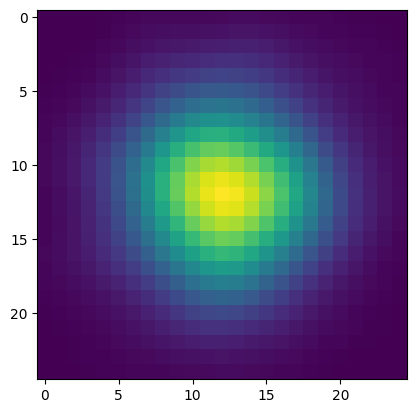

tf.Tensor([[8.208309]], shape=(1, 1), dtype=float32)


In [200]:
s = mod.prior.sample(1000)
h = mod.Hist2D(s)
plt.imshow(h)
plt.show()
print(mod.disc(tf.reshape(h,(1,mod.bins,mod.bins))))

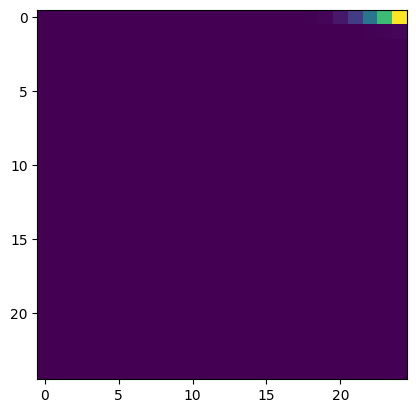

tf.Tensor([[-0.16997105]], shape=(1, 1), dtype=float32)


In [201]:
h = mod.Hist2D(mod.enc(test))
plt.imshow(h)
plt.show()
print(mod.disc(tf.reshape(h,(1,mod.bins,mod.bins))))

In [190]:
mod.disc.summary()

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 25, 25, 1)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 25, 25, 10)        260       
                                                                 
 conv2d_28 (Conv2D)          (None, 25, 25, 10)        2510      
                                                                 
 flatten_13 (Flatten)        (None, 6250)              0         
                                                                 
 dense_30 (Dense)            (None, 50)                312550    
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 315371 (1.20 MB)
Trainable params: 315371 (1

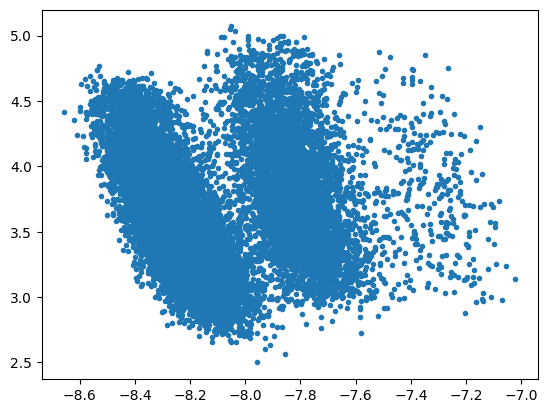

In [202]:
lows = mod.enc(test).numpy()

plt.scatter(lows[:,0],lows[:,1],marker='.')
plt.show()

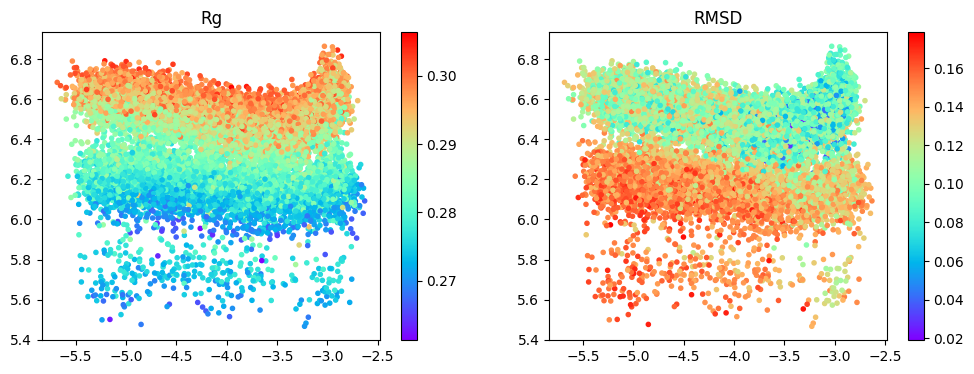

In [186]:
rg = md.compute_rg(X_test)
base = md.load(conf)
rmsd = md.rmsd(X_test,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

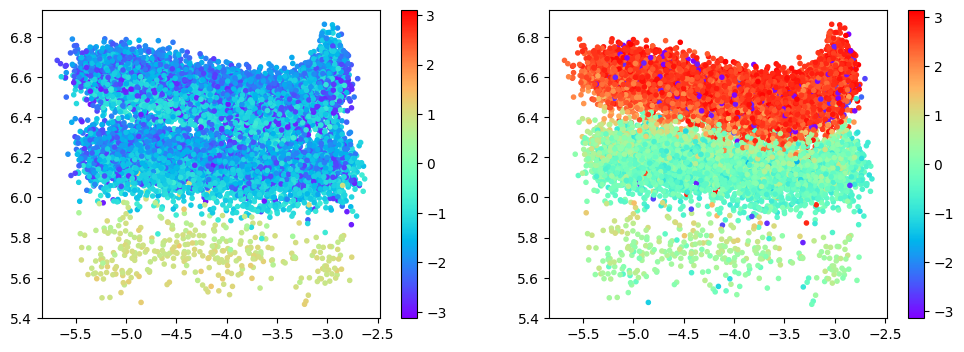

In [187]:
plt.figure(figsize=(12,4))
plt.subplot(121)
dih=md.compute_dihedrals(X_test,np.array([[4,6,8,14],[6,8,14,16]]))
plt.scatter(lows[:,0],lows[:,1],marker='.',c=dih[:,0],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=dih[:,1],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.show()

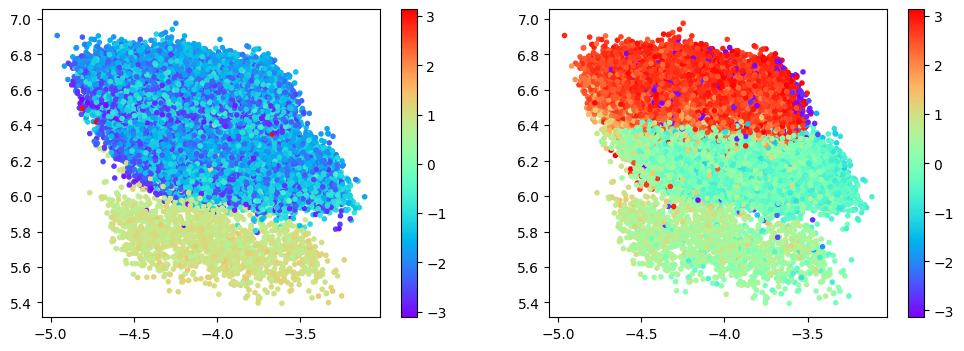

In [183]:
low_train = mod.enc(train).numpy()
plt.figure(figsize=(12,4))
plt.subplot(121)
dih=md.compute_dihedrals(X_train,np.array([[4,6,8,14],[6,8,14,16]]))
plt.scatter(low_train[:,0],low_train[:,1],marker='.',c=dih[:,0],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.subplot(122)
plt.scatter(low_train[:,0],low_train[:,1],marker='.',c=dih[:,1],cmap=cmap)
plt.colorbar(cmap=cmap)
plt.show()

In [ ]:
out_test = mod.dec(mod.enc(test))
np.mean(k.metrics.mean_squared_error(test,out_test).numpy())

In [ ]:
out_train = mod.dec(mod.enc(train))
np.mean(k.metrics.mean_squared_error(train,out_train).numpy())